# Importing packages

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime as dt
from dateutil.relativedelta import relativedelta
from yahoo_fin.stock_info import get_data,tickers_dow as dow,tickers_nasdaq as nasdaq,tickers_sp500 as sp500,get_premarket_price,get_postmarket_price
from yahoo_fin.options import get_calls,get_puts,get_expiration_dates

# Calculating Bollinger Bands

In [12]:
# Step 1: Calculate SMA (20-period)
def get_SMA(closing_prices, days):
    return closing_prices.rolling(days).mean()
# Step 2: Calculate std. deviation (14-period)
def get_std_dev(closing_prices, days):
    return closing_prices.rolling(days).std()
# Step 3: Create Bollinger Bands (1.5 std dev)
def get_BB(closing_prices, SMA_days, std_dev_days, rate):
    sma = get_SMA(closing_prices, SMA_days)
    std_dev = get_std_dev(closing_prices, std_dev_days)
    upper_bollinger = sma + std_dev*rate
    lower_bollinger = sma - std_dev*rate
    return upper_bollinger,lower_bollinger

# Calculating Keltner Channels

In [13]:
# Step 1: Calculate EMA (20-period)
def get_EMA(closing_prices, days):
    multiplier = 2 / (days + 1)
    ema = [closing_prices[0]]
    for price,EMA_yesterday in zip(closing_prices[1:],ema):
        ema.append(price * multiplier + EMA_yesterday * (1 - multiplier))
    return ema
# Step 2: Calculate ATR (20-period)
def get_ATR(high_prices,low_prices,closing_prices,days):
    high_low = high_prices-low_prices
    high_close = np.abs(high_prices-closing_prices.shift())
    low_close = np.abs(low_prices-closing_prices.shift())
    ranges = pd.concat([high_low,high_close,low_close],axis=1)
    trueRange = np.max(ranges,axis=1)
    atr = trueRange.rolling(days).sum()/days
    return atr
# Step 3: Calculate Keltner Channel
def get_KC(ema,shift,atr):
    upper_kc = ema + shift*atr
    lower_kc = ema - shift*atr
    return upper_kc,lower_kc

# Calculate Momentum

In [14]:
def get_momentum(closing_prices,days):
    momentum = []
    for day in range(days):
        momentum.insert(day,None)
    for current_price,previous_price in zip(closing_prices[days:],closing_prices):
        momentum.append(current_price - previous_price)
    return momentum

# Gather data

In [15]:
def gather_data(data):
    if not isinstance(data,pd.core.frame.DataFrame):
        df = pd.read_csv(data)
    else:
        df = data
    closing_prices = df['close']
    high_prices = df['high']
    low_prices = df['low']
    df['SMA'] = get_SMA(closing_prices,20)
    df['EMA'] = get_EMA(closing_prices,20)
    df['ATR'] = get_ATR(high_prices,low_prices,closing_prices,14)
    df['upper_KC'],df['lower_KC'] = get_KC(df['EMA'],1.5,df['ATR'])
    df['bollinger_up'],df['bollinger_down'] = get_BB(closing_prices,20,14,1.5)
    df['MA'] = get_SMA(closing_prices,14)
    df['momentum'] = get_momentum(closing_prices,14)
    return df

# Get Nasdaq 100 Tickers

In [16]:
def get_nasdaq100():
    tickers = []
    headers={"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"}
    res = requests.get("https://api.nasdaq.com/api/quote/list-type/nasdaq100", headers=headers)
    main_data = res.json()['data']['data']['rows']
    for company in main_data:
        tickers.append(company['symbol'])
    return tickers

# Screener Algorithm

In [17]:
def screener(company):
    calls = ''
    puts = ''
    #fails = ''
    one_day_streak = ''
    two_days_streak = ''
    three_days_streak = ''
    four_days_streak = ''
    days_to_check = [-1,-2,-3,-4,-5]
    current_status = ''
    for day in days_to_check:
        today = company.iloc[day]
        ticker = today['ticker']
        today_price = today['close']
        today_upper_kc = today['upper_KC']
        today_lower_kc = today['lower_KC']
        today_upper_bb = today['bollinger_up']
        today_lower_bb = today['bollinger_down']
        today_ma = today['MA']
        today_momentum = today['momentum']
        if(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price > today_ma and today_momentum > 0 and current_status!='put'):
            calls = ticker
            current_status = 'call'
        elif(today_upper_bb < today_upper_kc and today_lower_bb > today_lower_kc and today_price < today_ma and today_momentum < 0 and current_status!='call'):
            puts = ticker
            current_status = 'put'
        else:
            if day ==-5:
                calls = ''
                puts = ''
                four_days_streak = ticker + ' - ' + current_status
            elif day ==-4:
                calls = ''
                puts = ''
                three_days_streak = ticker + ' - ' + current_status
            elif day ==-3:
                calls = ''
                puts = ''
                two_days_streak = ticker + ' - ' + current_status
            elif day ==-2:
                calls = ''
                puts = ''
                one_day_streak = ticker + ' - ' + current_status
            break
    return calls,puts,one_day_streak,two_days_streak,three_days_streak,four_days_streak

# Screener

In [18]:
today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))

calls = []
puts = []
fails = []
ones = []
twos = []
threes = []
fours = []

# Check an index
def check_index(function):
    index = function()
    index_hist = {}
    for ticker in index:
        data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
        company = gather_data(data)
        company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
        if company_calls!='':
            calls.append(company_calls)
        if company_puts!='':
            puts.append(company_puts)
        if company_ones!='':
            ones.append(company_ones)
        if company_twos!='':
            twos.append(company_twos)
        if company_threes!='':
            threes.append(company_threes)
        if company_fours!='':
            fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours


# Check individual stock
def check_stock(ticker):
    data = get_data(ticker, start_date = last_year, end_date = today, index_as_date = True, interval = '1d')
    company = gather_data(data)
    company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
    if company_calls!='':
        calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_ones!='':
        ones.append(company_ones)
    if company_twos!='':
        twos.append(company_twos)
    if company_threes!='':
        threes.append(company_threes)
    if company_fours!='':
        fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours

# Check custom stock
def check_custom_stock(csv):
    company = gather_data(csv)
    company_calls,company_puts,company_ones,company_twos,company_threes,company_fours = screener(company)
    if company_calls!='':
        calls.append(company_calls)
    if company_puts!='':
        puts.append(company_puts)
    if company_ones!='':
        ones.append(company_ones)
    if company_twos!='':
        twos.append(company_twos)
    if company_threes!='':
        threes.append(company_threes)
    if company_fours!='':
        fours.append(company_fours)
    return calls,puts,ones,twos,threes,fours

# Check Nasdaq-100

In [19]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_index(get_nasdaq100)
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

Calls (1): ['ALGN']
Puts (4): ['ADSK', 'PEP', 'FTNT', 'ZM']
4-days Streak (1): ['ODFL - put']
3-days Streak (1): ['DXCM - put']
2-days Streak (10): ['REGN - put', 'IDXX - put', 'BIIB - put', 'SNPS - put', 'EXC - call', 'PYPL - put', 'KHC - call', 'ZS - put', 'AMZN - put', 'CEG - put']
1-day Streak (18): ['KLAC - put', 'CTAS - put', 'MNST - put', 'FISV - put', 'ORLY - put', 'DLTR - put', 'ANSS - put', 'CDNS - put', 'HON - put', 'ATVI - put', 'ENPH - put', 'FANG - put', 'META - put', 'WDAY - put', 'JD - put', 'TEAM - put', 'BKR - put', 'PDD - put']


# Check S&P500

In [10]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_index(sp500)
#stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_stock('CFG')
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

Calls (8): ['ACGL', 'ALGN', 'BA', 'DHI', 'LW', 'PCG', 'SJM', 'VRSN']
Puts (17): ['ADSK', 'AMT', 'CHRW', 'DRI', 'FTNT', 'GNRC', 'K', 'LNT', 'LUMN', 'MMM', 'NI', 'NOW', 'PEP', 'SIVB', 'TTWO', 'VTRS', 'WHR']
4-days Streak (7): ['FCX - put', 'JBHT - put', 'ODFL - put', 'SPG - put', 'VTR - put', 'WY - put', 'ZBH - call']
3-days Streak (16): ['BIO - put', 'BWA - put', 'CAG - call', 'COO - call', 'DVA - put', 'DXCM - put', 'GIS - put', 'HD - put', 'HII - put', 'HSIC - put', 'MO - put', 'NEE - put', 'WST - put', 'WTW - put', 'WYNN - put', 'YUM - put']
2-days Streak (35): ['ADM - call', 'ALL - call', 'AMZN - put', 'BDX - call', 'BIIB - put', 'BSX - put', 'C - put', 'CAT - call', 'CDAY - put', 'CEG - put', 'CI - call', 'CL - call', 'DGX - call', 'DUK - call', 'EL - call', 'EQT - put', 'EXC - call', 'HCA - call', 'IDXX - put', 'KHC - call', 'LEN - call', 'LOW - put', 'LYV - put', 'MDT - put', 'MRK - call', 'OXY - put', 'PAYC - put', 'PG - call', 'PHM - call', 'PKI - call', 'PM - put', 'PYPL - put

# Check individual stock

In [ ]:
calls = []
puts = []
ones = []
twos = []
threes = []
fours = []

stock_calls,stock_puts,stock_ones,stock_twos,stock_threes,stock_fours = check_stock('CFG')
print(f'Calls ({len(stock_calls)}): {stock_calls}\nPuts ({len(stock_puts)}): {stock_puts}\n4-days Streak ({len(stock_fours)}): {stock_fours}\n3-days Streak ({len(stock_threes)}): {stock_threes}\n2-days Streak ({len(stock_twos)}): {stock_twos}\n1-day Streak ({len(stock_ones)}): {stock_ones}')

# Get pre/post market prices

In [9]:
def is_premarket(current):
    start = dt.time(4,0,0)
    end = dt.time(9,30,0)
    return start<=current<=end

def is_postmarket(current):
    start = dt.time(16,0,0)
    end = dt.time(20,0,0)
    return start<=current<=end

def get_pre_post_market(ticker,current_hour):
    if is_premarket(current_hour):
        data = f'{ticker} Premarket: {get_premarket_price(ticker)}'
    elif is_postmarket(current_hour):
        data = f'{ticker} Postmarket: {get_postmarket_price(ticker)}'
    else:
        data = f'{ticker} Not pre/post market'
    #company = gather_data(data)
    print(data)

current_hour = dt.datetime.now().time()
get_pre_post_market('CL',current_hour)

CL Not pre/post market


# Plotter

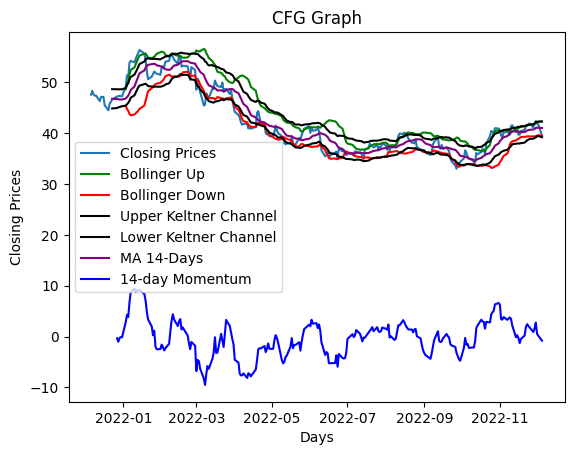

In [9]:
%matplotlib inline

today = dt.date.today()
last_year = (dt.datetime.now()-relativedelta(years=1))
ticker = 'CFG'
data = get_data(ticker=ticker, start_date = last_year, end_date = None, index_as_date = True, interval = '1d')
df = gather_data(data)
plt.title(ticker + ' Graph')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['close'], label='Closing Prices')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='green')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='red')
plt.plot(df['upper_KC'], label='Upper Keltner Channel', c='black')
plt.plot(df['lower_KC'], label='Lower Keltner Channel', c='black')
plt.plot(df['MA'], label='MA 14-Days', c='purple')
plt.plot(df['momentum'], label='14-day Momentum', c='blue')
plt.legend()
plt.show()